# **Práctica - Aplicación del Muestreo**

[Victor Sanchez](https://github.com/VicoSan07) <br>
Dataset: [Anime List Dataset](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset)

En esta práctica compararemos la eficacia de aplicar un muestreo estratificado sobre la puntuación o score de una lista de animes, respecto a un muestreo por conveniencia.

In [126]:
#Librerias basicas
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
from google.colab import files
uploaded = files.upload()

In [145]:
#Lectura de archivo
Anime_DB = pd.read_csv("anime-filtered.csv",delimiter = ",")
Anime_DB.head()

,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108


In [146]:
#Se remueven los animes de tipo no identificado: 36 desconocidos
indexType = Anime_DB[ Anime_DB['Type'] == 'Unknown'].index
Anime_DB.drop(indexType , inplace=True)

In [147]:
#Se obtiene el tamaño de cada estrato
InfoType = Anime_DB.groupby(['Type'], as_index=False).size()
InfoType.columns = ['Type','Size']
InfoType

,Type,Size
0,Movie,2636
1,Music,744
2,ONA,1531
3,OVA,3364
4,Special,1991
5,TV,4650


In [187]:
#De cada estrato se obtiene su respectiva media y se pondera para obtener la media poblacional
#(en función del tamaño de los estratos)
InfoScore = pd.DataFrame(Anime_DB.groupby(['Type'], as_index=False)['Completed'].mean())
InfoScore.columns = ['Type','ScoreA']
ResumeDB = pd.merge(InfoType, InfoScore, on="Type")
ResumeDB['Apond'] = ResumeDB['Size']/len(Anime_DB)*ResumeDB['ScoreA']
popmean = ResumeDB['Apond'].sum()
popmean

26005.710713327968

In [199]:
#A partir de aquí se obtiene una muestra aleatoria estratificada del 20% con una asignación proporcional, es decir ni =Ni/N
Anime_DBSample1 = Anime_DB.groupby('Type', group_keys=False).apply(lambda x: x.sample( mt.ceil( (len(x)/len(Anime_DB))*mt.ceil(len(Anime_DB)*0.2) )  ))

In [200]:
#Se obtiene la media estratificada estimada para la muestra seleccionada
InfoTypeSample1 = Anime_DBSample1.groupby(['Type'], as_index=False).size()
InfoTypeSample1.columns = ['Type','Size']
InfoScoreSample1 = pd.DataFrame(Anime_DBSample1.groupby(['Type'], as_index=False)['Completed'].mean())
InfoScoreSample1.columns = ['Type','ScoreA']
ResumeDBSample1 = pd.merge(InfoTypeSample1, InfoScoreSample1, on="Type")
ResumeDBSample1['Apond'] = ResumeDBSample1['Size']/len(Anime_DBSample1)*ResumeDBSample1['ScoreA']
samplemean = ResumeDBSample1['Apond'].sum()
samplemean

28753.200200870437

In [201]:
#¿Y si probamos la Ley de los Grandes Números? en conjunto con el Teorema del Límite Central
n_iter = 1000
samplemeans_array = np.zeros(n_iter)

#filling the array with loop
for i in range(0,n_iter):
    Anime_DBSample1 = Anime_DB.groupby('Type', group_keys=False).apply(lambda x: x.sample( mt.ceil( (len(x)/len(Anime_DB))*mt.ceil(len(Anime_DB)*0.2) )  ))
    InfoTypeSample1 = Anime_DBSample1.groupby(['Type'], as_index=False).size()
    InfoTypeSample1.columns = ['Type','Size']
    InfoScoreSample1 = pd.DataFrame(Anime_DBSample1.groupby(['Type'], as_index=False)['Completed'].mean())
    InfoScoreSample1.columns = ['Type','ScoreA']
    ResumeDBSample1 = pd.merge(InfoTypeSample1, InfoScoreSample1, on="Type")
    ResumeDBSample1['Apond'] = ResumeDBSample1['Size']/len(Anime_DBSample1)*ResumeDBSample1['ScoreA']
    samplemean = ResumeDBSample1['Apond'].sum()
    samplemeans_array[i] = samplemean #filling  x_array

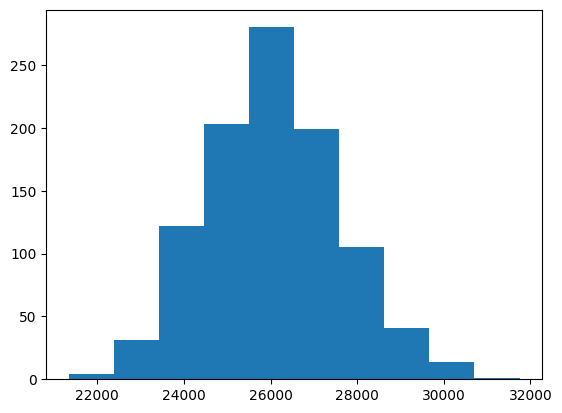

In [202]:
plt.hist(samplemeans_array)
plt.show()

In [203]:
#Media muestral estimada
samplemeans_array.mean()

26055.904215266153

In [205]:
#Margen de Error (en porcentaje)
abs(popmean-samplemeans_array.mean())/samplemeans_array.mean()*100

0.1926377281843744

In [206]:
#¿Y si el muestreo es por conveniencia? Buscando generar una estadística falsa de que los animes cuentan con un buen número promedio de espectadores que los completan
Anime_DBSample2 = Anime_DB[ Anime_DB['Ranked'] > mt.ceil(len(Anime_DB)*0.2)  ]
InfoTypeSample2 = Anime_DBSample2.groupby(['Type'], as_index=False).size()
InfoTypeSample2.columns = ['Type','Size']
InfoScoreSample2 = pd.DataFrame(Anime_DBSample1.groupby(['Type'], as_index=False)['Completed'].mean())
InfoScoreSample2.columns = ['Type','ScoreA']
ResumeDBSample2 = pd.merge(InfoTypeSample2, InfoScoreSample2, on="Type")
ResumeDBSample2['Apond'] = ResumeDBSample2['Size']/len(Anime_DBSample2)*ResumeDBSample2['ScoreA']
samplemean2 = ResumeDBSample2['Apond'].sum()
samplemean2

24778.614498242325

In [208]:
#Margen de Error (en porcentaje)
abs(popmean-samplemean2)/samplemean2*100
#Nota: El margen de error no tiene relevancia estadísitica en este segundo muestreo al provenir de una muestra no probabílistica, por lo que se sugiere omitirlo

4.952239017127804

#### Conclusiones

A tráves de esta práctica logramos observar las ventajas de utilizar técnicas de muestreo probabilísticas frente a muestreos no aleatorios, los cuales no son posibles de validar su significancia estadística derivada del sesgo inherente que llevan. En este caso partícular, el Muestreo Sistemático tuvo una cota de error más pequeña respecto al estimador poblacional.
Por otra parte, validamos el teorema de límite central el cual nos dice que entre más grande sea el tamaño de muestra de una población, la distribución de sus medias muestrales tenderá a una normal, como corroboramos en el histograma